In [8]:
from loguru import logger
import io3d
import io3d.datasets
import sed3
import numpy as np
import matplotlib.pyplot as plt
logger.enable("io3d")
logger.disable("io3d")

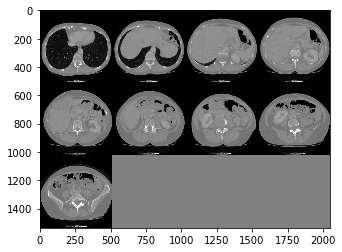

In [9]:
datap1 = io3d.datasets.read_dataset("3Dircadb1", "data3d", 1)
sed3.show_slices(datap1["data3d"], slice_step=16)

In [32]:
def create_train_data(label="train", datasets=None):
    
    imgs_train = [] 
    masks_train = []    
    if not datasets:
        datasets = {
            "3Dircadb1": {"start":1, "stop":2},
            "sliver07": {"start":0, "stop":0}
        }
    for dataset in datasets:
        
        for i in range(
            datasets[dataset]["start"], 
            datasets[dataset]["stop"]
        ):
            print(f"{dataset} {i}")
            data3dp = io3d.datasets.read_dataset(dataset, "data3d", i)
            segm3dp = io3d.datasets.read_dataset(dataset, "liver", i)

            data3d = data3dp["data3d"]
            segm3d = segm3dp["data3d"]

            for j in range(0, data3d.shape[0]):
                imgs_train.append(data3d[j,:,:])
                masks_train.append(segm3d[j,:,:])
                
    imgs_train = np.array(imgs_train)
    masks_train = np.array(masks_train)
    np.save(f'imgs_{label}.npy', imgs_train)
    np.save(f'masks_{label}.npy', masks_train)
    print('Saving to .npy files done.')
    return imgs_train, masks_train
            

In [41]:
def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    masks_train = np.load('masks_train.npy')
    return imgs_train, masks_train
def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    masks_test = np.load('masks_test.npy')
    return imgs_test, masks_test

In [34]:
create_train_data(
    "train",
    datasets={
        "3Dircadb1": {"start":1, "stop":8},
        "sliver07": {"start":0, "stop":0}
    }
)
create_train_data(
    "test",
    datasets={
        "3Dircadb1": {"start":10, "stop":11},
        "sliver07": {"start":0, "stop":0}
    }
)

3Dircadb1 1
3Dircadb1 2
3Dircadb1 3
3Dircadb1 4
3Dircadb1 5
3Dircadb1 6
3Dircadb1 7
Saving to .npy files done.
3Dircadb1 10
Saving to .npy files done.


(array([[[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048]],
 
        [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048]],
 
        [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, 

(129, 512, 512)

# CNN

'''
conda install -c conda-forge keras-applications
'''

In [45]:

from __future__ import print_function

import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data

In [46]:

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.
#We divide here the number of rows and columns by two because we undersample our data (We take one pixel over two)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#The functions return our metric and loss

In [37]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [47]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

#We adapt here our dataset samples dimension so that we can feed it to our network

In [48]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

    imgs_mask_train = imgs_mask_train.astype('float32')

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=10, epochs=20, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_maskt = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1))
        b=(imgs_mask_test[k][:,:,0]).astype('uint8')
        io.imsave(os.path.join(pred_dir, str(k) + '_pred.png'),mark_boundaries(a,b))
    #Saving our predictions in the directory 'preds'
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

In [49]:
train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------


AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'